In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/innova-hackathon/hackathon 2024 - Yapay Zeka.xlsx


In [245]:
pip install holidays


Note: you may need to restart the kernel to use updated packages.


In [242]:
!pip install prophet


In [594]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer #imputatio 
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from pyod.models.iforest import IForest 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

import holidays


In [278]:
from prophet import Prophet


In [279]:
#set display screen
pd.set_option("display.max_columns",None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

# 1. Data Preprocessing

In [490]:
#read the data
df = pd.read_excel("/kaggle/input/innova-hackathon/hackathon 2024 - Yapay Zeka.xlsx") 

In [304]:
df.head()

,TIME_STAMP,SERVER_NAME,DOWNLOAD,UPLOAD
0,2024-03-05 18:25:00,10.0.901.xx Server 1,11927.017,424.700
1,2024-03-05 18:20:00,10.0.901.xx Server 1,19703.467,525.575
2,2024-03-05 18:15:00,10.0.901.xx Server 1,26349.663,631.144
3,2024-03-05 18:10:00,10.0.901.xx Server 1,26068.494,623.673
4,2024-03-05 18:05:00,10.0.901.xx Server 1,25814.357,620.701


In [149]:
df.shape 

(35429, 4)

In [305]:
df.isnull().sum() # DOWNLOAD and UPLOAD columns includes two missing values.

TIME_STAMP     0
SERVER_NAME    0
DOWNLOAD       2
UPLOAD         2
dtype: int64

In [491]:
df['TIME_STAMP'] = pd.to_datetime(df['TIME_STAMP']) # Convert TIME_STAMP to datatime

In [492]:
df.head()

,TIME_STAMP,SERVER_NAME,DOWNLOAD,UPLOAD
0,2024-03-05 18:25:00,10.0.901.xx Server 1,11927.017,424.700
1,2024-03-05 18:20:00,10.0.901.xx Server 1,19703.467,525.575
2,2024-03-05 18:15:00,10.0.901.xx Server 1,26349.663,631.144
3,2024-03-05 18:10:00,10.0.901.xx Server 1,26068.494,623.673
4,2024-03-05 18:05:00,10.0.901.xx Server 1,25814.357,620.701


# 1.1 Feature Engineering

In [493]:
df['HOUR'] = df['TIME_STAMP'].dt.hour
df['DAY_OF_WEEK'] = df['TIME_STAMP'].dt.dayofweek  # Monday=0, Sunday=6
df['WEEKEND'] = df['DAY_OF_WEEK'] >= 5  # True if Saturday or Sunday
df['MINUTE'] = df['TIME_STAMP'].dt.minute
df["TIME"] = df["HOUR"]*df["MINUTE"] #Interaction
df['NIGHT'] = df['HOUR'].apply(lambda x: 0 if x < 12 else 1)


In [494]:
df['WEEKEND'] = df['WEEKEND'].map({False: 0, True: 1}) 

In [495]:
# Holidays of Turkey
multi_year_holidays = holidays.Turkey(years=[2023, 2024])

In [496]:
# Discard dates from the multi_year_holidays
dholiday_dates = pd.to_datetime(list(multi_year_holidays.keys())).date


In [497]:
# Add HOLIDAY column to dataset
df['HOLIDAY'] = 0

In [498]:
# Discard only date
df['DATE_ONLY'] = df['TIME_STAMP'].dt.date


In [499]:
# Match the Holidays of Turkey with the dataset's dates
df.loc[df['DATE_ONLY'].isin(dholiday_dates), 'HOLIDAY'] = 1


In [500]:
df.drop(columns=['DATE_ONLY'], inplace=True)

In [501]:
df.head()

,TIME_STAMP,SERVER_NAME,DOWNLOAD,UPLOAD,HOUR,DAY_OF_WEEK,WEEKEND,MINUTE,TIME,NIGHT,HOLIDAY
0,2024-03-05 18:25:00,10.0.901.xx Server 1,11927.017,424.700,18,1,0,25,450,1,0
1,2024-03-05 18:20:00,10.0.901.xx Server 1,19703.467,525.575,18,1,0,20,360,1,0
2,2024-03-05 18:15:00,10.0.901.xx Server 1,26349.663,631.144,18,1,0,15,270,1,0
3,2024-03-05 18:10:00,10.0.901.xx Server 1,26068.494,623.673,18,1,0,10,180,1,0
4,2024-03-05 18:05:00,10.0.901.xx Server 1,25814.357,620.701,18,1,0,5,90,1,0


In [502]:
df.drop("DAY_OF_WEEK", axis=1, inplace=True) #drop the DAY_OF_WEEK column


# 1.2 IMPUTATION

In [503]:
numeric_data = df[["DOWNLOAD","UPLOAD"]]


In [504]:
imputer = KNNImputer(n_neighbors=5) # if you find time check for the k


In [505]:
imputed_data = imputer.fit_transform(numeric_data)


In [506]:
# Change to dataframe
data_imputed = pd.DataFrame(imputed_data, columns=numeric_data.columns)

In [507]:
df["DOWNLOAD"] = data_imputed["DOWNLOAD"]
df["UPLOAD"] = data_imputed["UPLOAD"]

# 1.3 Data Manipulation

In [508]:
# Reverse the order of the rows based on the TIME_STAMP 
df = df.sort_values(by='TIME_STAMP', ascending=True).reset_index(drop=True)

In [509]:
df.drop(columns=['SERVER_NAME'],inplace=True)

In [510]:
df.head()

,TIME_STAMP,DOWNLOAD,UPLOAD,HOUR,WEEKEND,MINUTE,TIME,NIGHT,HOLIDAY
0,2023-11-02 10:10:00,14611.335,357.395,10,0,10,100,0,0
1,2023-11-02 10:15:00,14336.298,355.811,10,0,15,150,0,0
2,2023-11-02 10:20:00,14381.373,357.816,10,0,20,200,0,0
3,2023-11-02 10:25:00,14461.797,358.717,10,0,25,250,0,0
4,2023-11-02 10:30:00,14604.990,364.365,10,0,30,300,0,0


In [511]:
cor_df = df[["DOWNLOAD","UPLOAD","HOUR","WEEKEND","MINUTE","HOLIDAY","TIME","NIGHT"]]
corrmat = cor_df.corr()
corrmat

,DOWNLOAD,UPLOAD,HOUR,WEEKEND,MINUTE,HOLIDAY,TIME,NIGHT
DOWNLOAD,1.000000,0.993715,0.712864,0.115527,0.004837,0.026028,0.480629,0.672958
UPLOAD,0.993715,1.000000,0.727733,0.099037,0.000601,0.032494,0.485837,0.691042
HOUR,0.712864,0.727733,1.000000,-0.000693,-0.005866,-0.000083,0.633950,0.866345
WEEKEND,0.115527,0.099037,-0.000693,1.000000,0.000026,-0.057492,-0.000388,-0.001047
MINUTE,0.004837,0.000601,-0.005866,0.000026,1.000000,0.000018,0.659904,-0.003877
HOLIDAY,0.026028,0.032494,-0.000083,-0.057492,0.000018,1.000000,-0.000027,-0.000139
TIME,0.480629,0.485837,0.633950,-0.000388,0.659904,-0.000027,1.000000,0.549773
NIGHT,0.672958,0.691042,0.866345,-0.001047,-0.003877,-0.000139,0.549773,1.000000


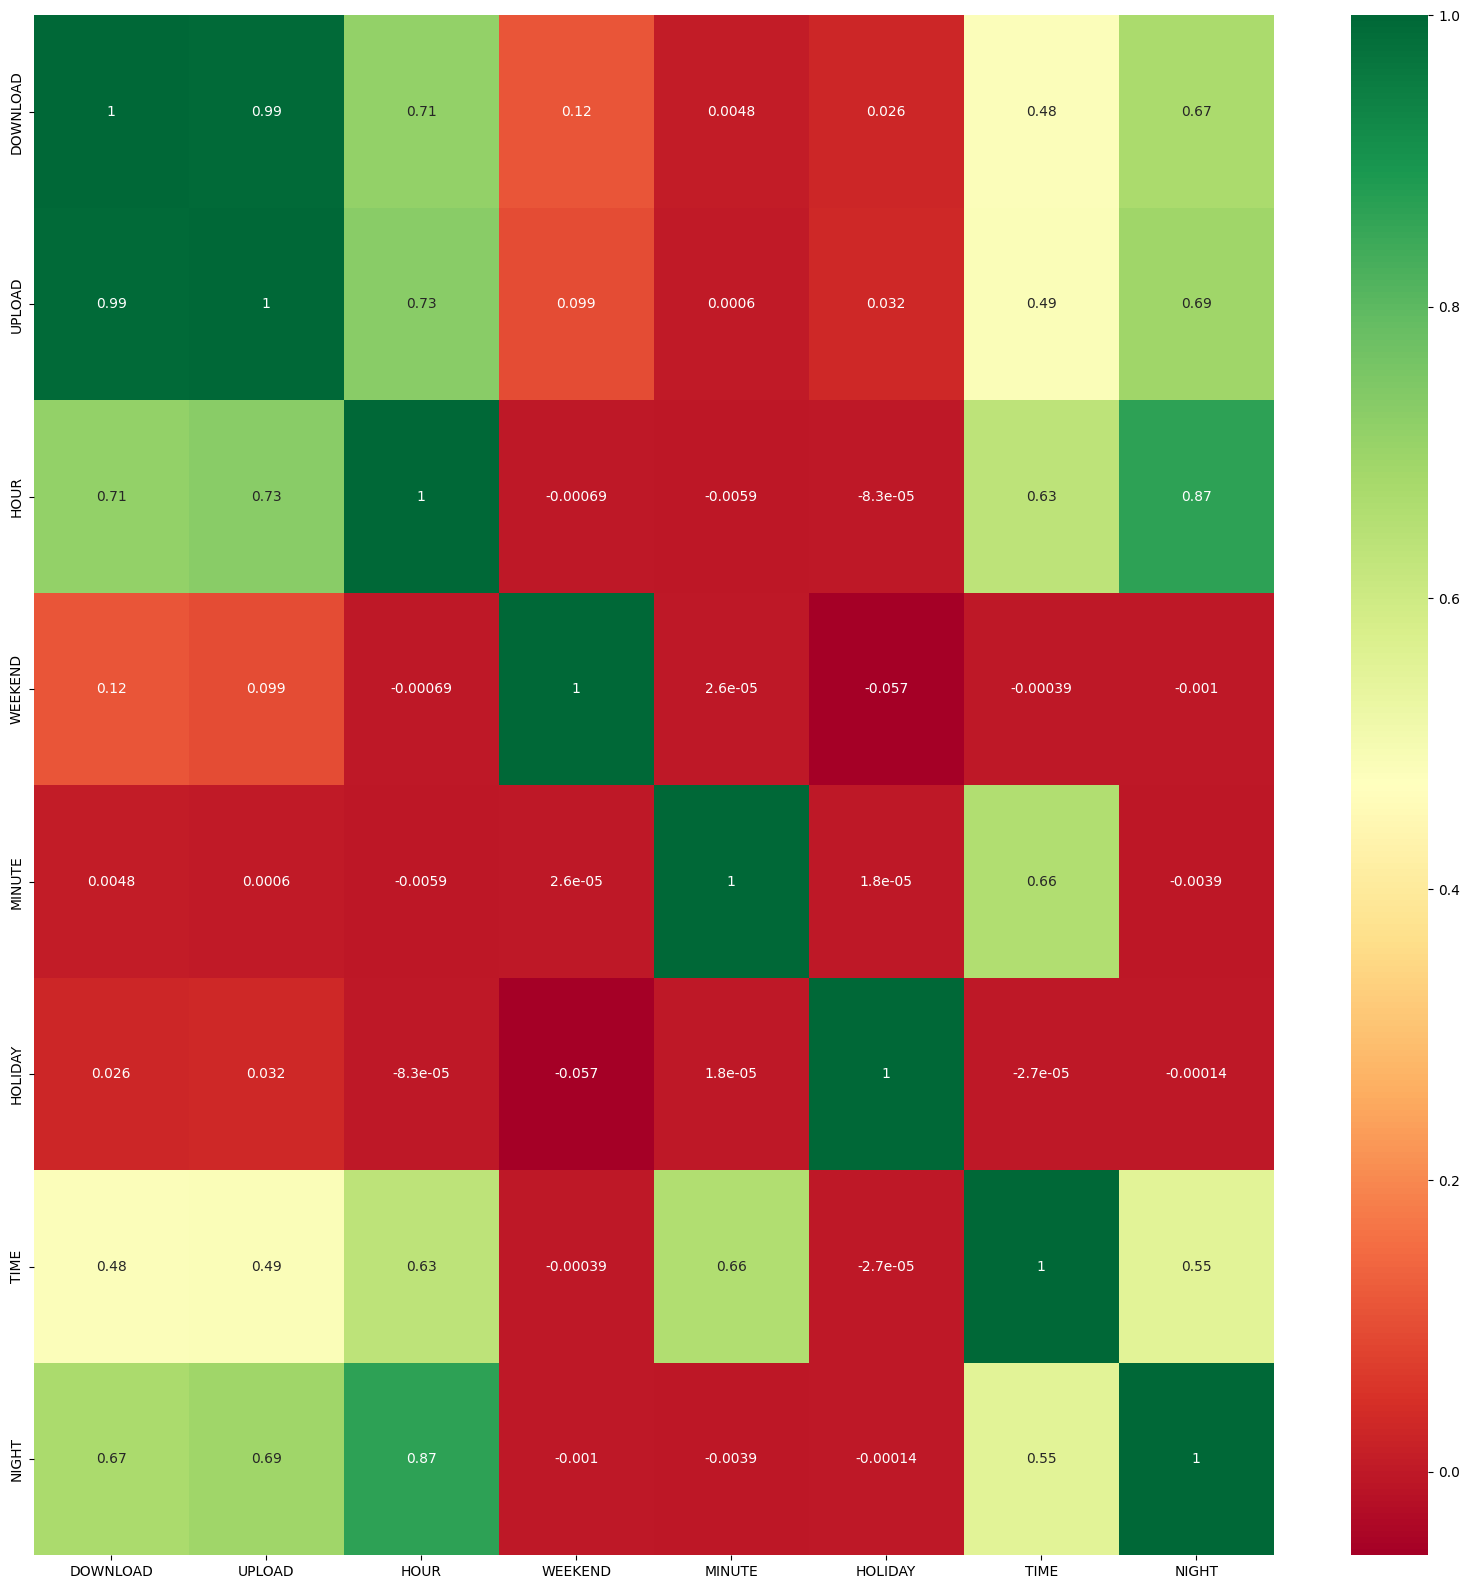

In [512]:
# corr matrix
top_corr_features =corrmat.index
plt.figure(figsize=(20,20))
g = sns.heatmap(corrmat[top_corr_features],annot = True,cmap="RdYlGn")

# 1.4 Visualizations

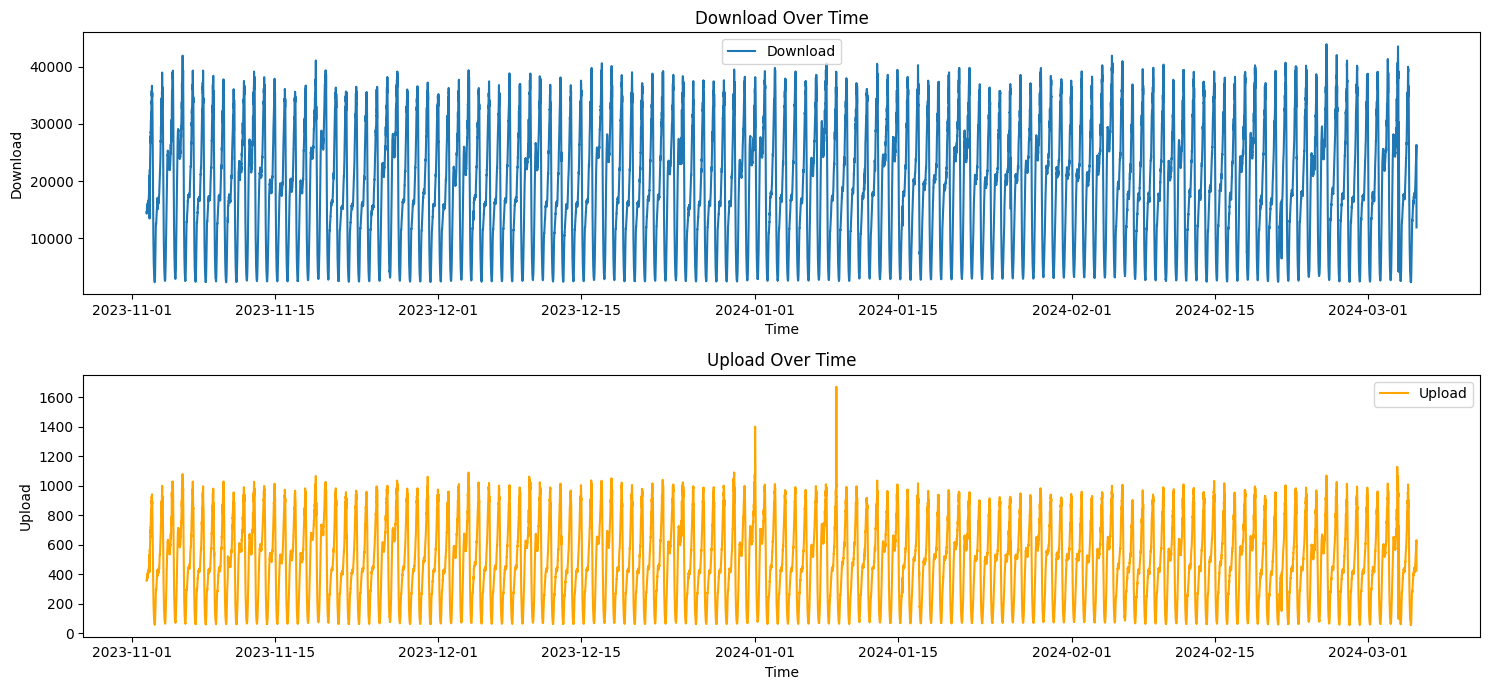

In [513]:
# Time series plot for DOWNLOAD and UPLOAD
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(df['TIME_STAMP'], df['DOWNLOAD'], label='Download')
plt.title('Download Over Time')
plt.xlabel('Time')
plt.ylabel('Download')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['TIME_STAMP'], df['UPLOAD'], label='Upload', color='orange')
plt.title('Upload Over Time')
plt.xlabel('Time')
plt.ylabel('Upload')
plt.legend()

plt.tight_layout()
plt.show()

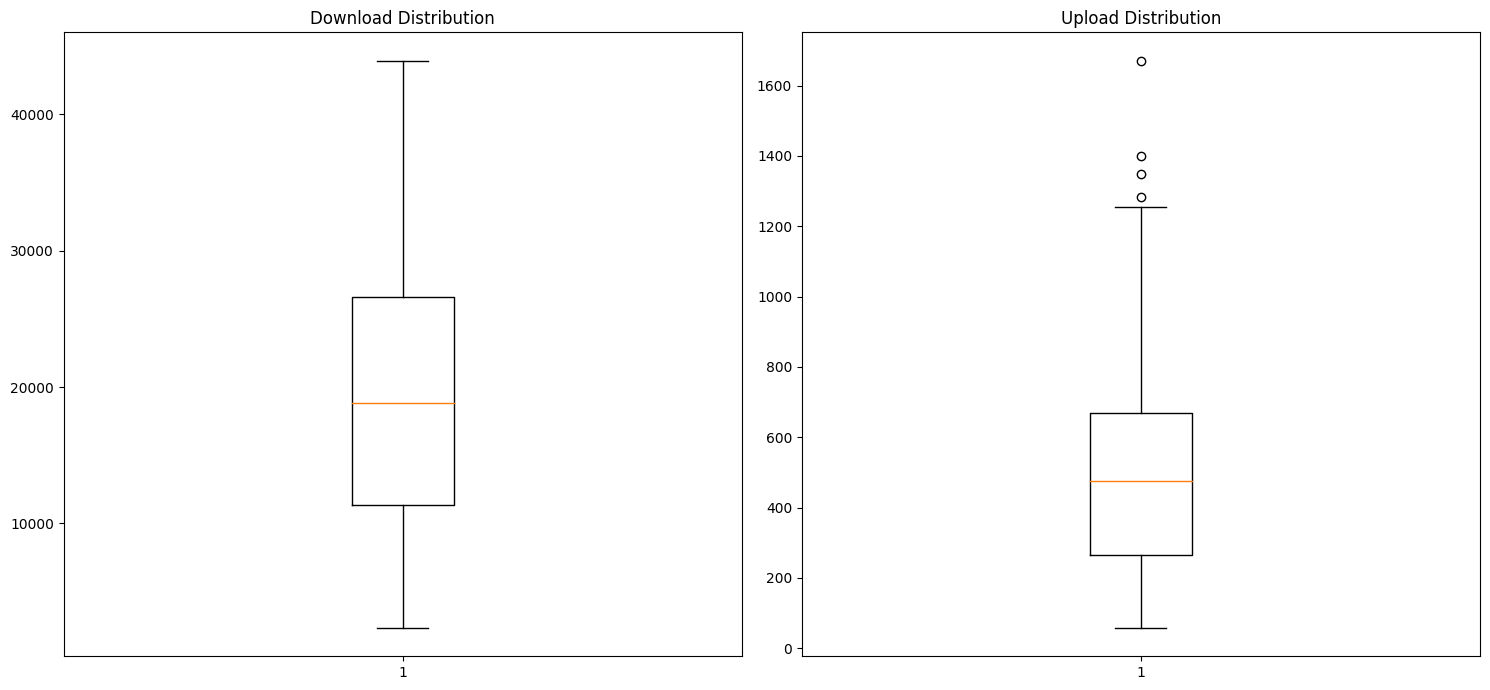

In [122]:
#Boxplot to check for anomalies in DOWNLOAD and UPLOAD 
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.boxplot(df['DOWNLOAD'])
plt.title('Download Distribution')

plt.subplot(1, 2, 2)
plt.boxplot(df['UPLOAD'])
plt.title('Upload Distribution')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


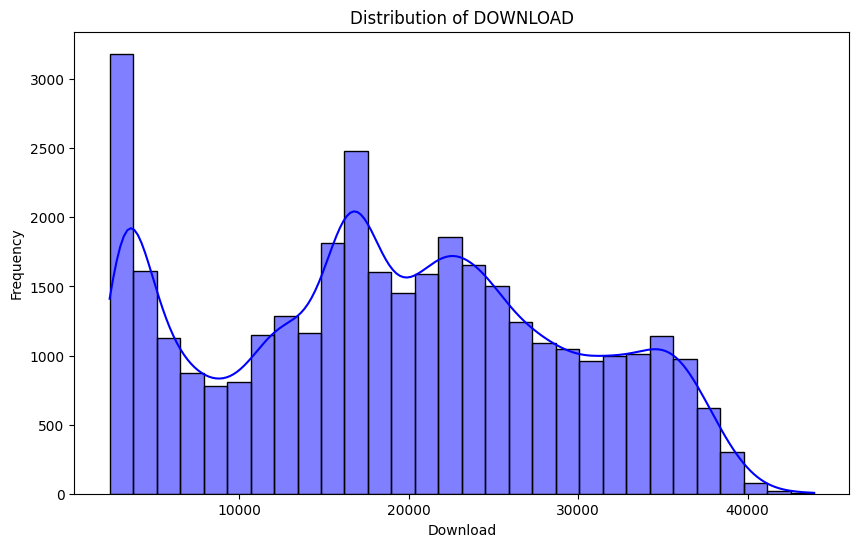

In [123]:
#Distribution of DOWNLOAD
plt.figure(figsize=(10, 6))
sns.histplot(df['DOWNLOAD'], bins=30, kde=True, color='blue')
plt.title('Distribution of DOWNLOAD')
plt.xlabel('Download')
plt.ylabel('Frequency')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


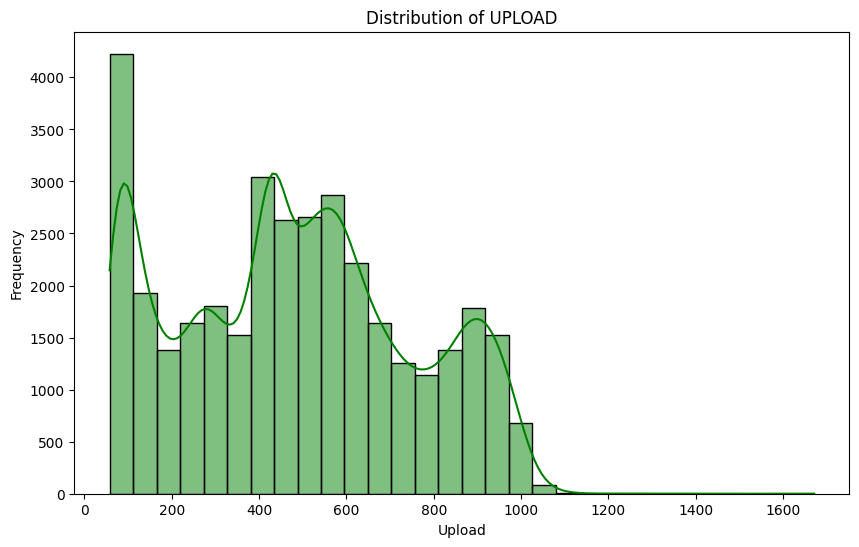

In [124]:
# Distribution of UPLOAD
plt.figure(figsize=(10, 6))
sns.histplot(df['UPLOAD'], bins=30, kde=True, color='green')
plt.title('Distribution of UPLOAD')
plt.xlabel('Upload')
plt.ylabel('Frequency')
plt.show()

# 2. Anomaly Detection

In [778]:
df["HOUR_MINUTE"] = df['TIME_STAMP'].dt.strftime('%H:%M')


In [780]:
# Filter data based on 18.25
filtered_df = df.loc[df['HOUR_MINUTE'] == '18:25']


In [781]:
#indicator variable for the check data point
df['FLAG'] = df['HOUR_MINUTE'].apply(lambda x: 1 if x == '18:25' else 0)


In [782]:
#Extract features 

features = df[["DOWNLOAD","UPLOAD","WEEKEND","TIME","NIGHT","HOLIDAY","FLAG"]]


In [783]:
# Build the model
iso_forest = IsolationForest(contamination=0.01,max_samples=256)

In [784]:
# Fit the data
iso_forest.fit(features) 

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_samples=256)

In [785]:
df["OUTLIER"]= iso_forest.predict(features)

In [786]:
df['OUTLIER'] = df['OUTLIER'].apply(lambda x: True if x == -1 else False)


In [788]:
outliers = df[df['OUTLIER']]


In [789]:
outliers.shape 


(355, 12)

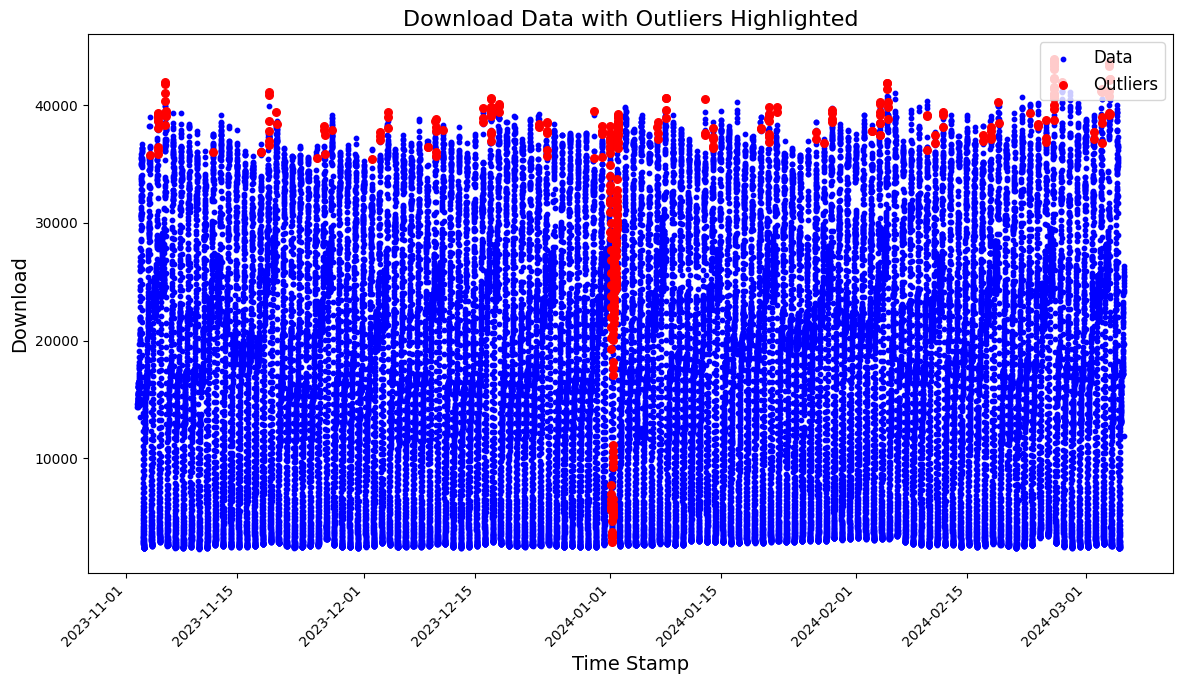

In [790]:
# Assuming df is your DataFrame and 'OUTLIER' is a column indicating the outliers
plt.figure(figsize=(14, 7))

# Plot the normal data points
plt.scatter(df['TIME_STAMP'], df['DOWNLOAD'], label='Data', color='blue', s=10)

# Plot the anomalies
outliers = df[df['OUTLIER'] == True]
plt.scatter(outliers['TIME_STAMP'], outliers['DOWNLOAD'], label='Outliers', color='red', s=30)

# Add titles and labels
plt.title('Download Data with Outliers Highlighted', fontsize=16)
plt.xlabel('Time Stamp', fontsize=14)
plt.ylabel('Download', fontsize=14)

# Enhance legend
plt.legend(loc='upper right', fontsize=12)

# Improve x-axis ticks
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

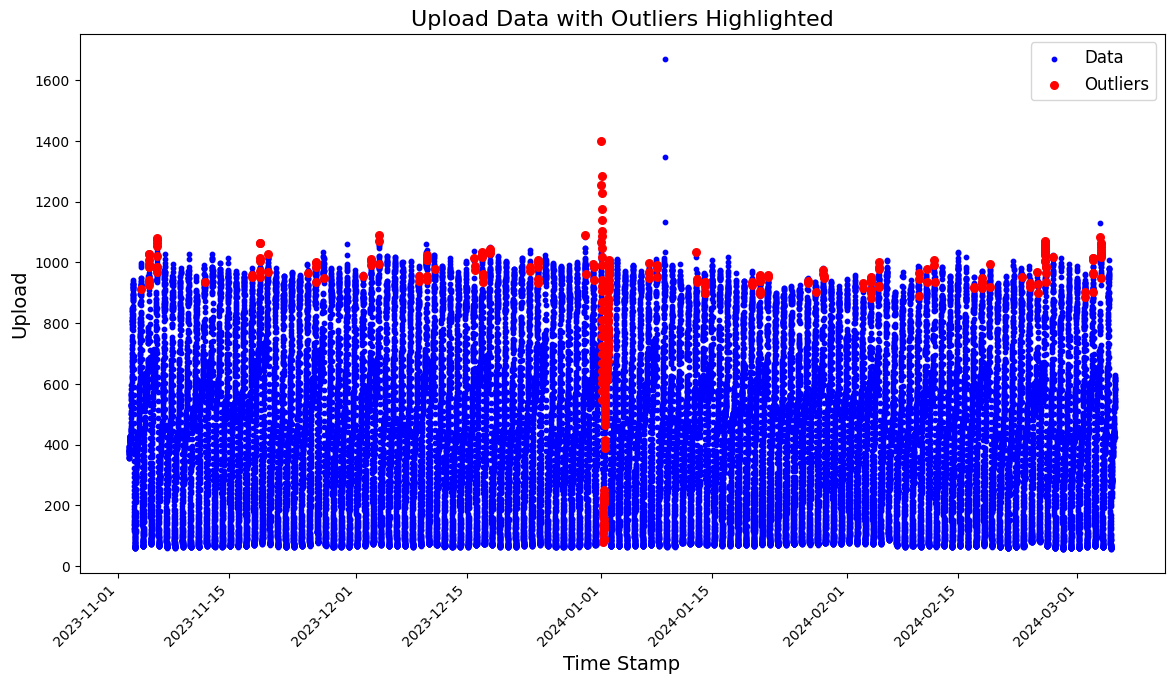

In [791]:
# Assuming df is your DataFrame and 'OUTLIER' is a column indicating the outliers
plt.figure(figsize=(14, 7))

# Plot the normal data points
plt.scatter(df['TIME_STAMP'], df['UPLOAD'], label='Data', color='blue', s=10)

# Plot the anomalies
outliers = df[df['OUTLIER'] == True]
plt.scatter(outliers['TIME_STAMP'], outliers['UPLOAD'], label='Outliers', color='red', s=30)

# Add titles and labels
plt.title('Upload Data with Outliers Highlighted', fontsize=16)
plt.xlabel('Time Stamp', fontsize=14)
plt.ylabel('Upload', fontsize=14)

# Enhance legend
plt.legend(loc='upper right', fontsize=12)

# Improve x-axis ticks
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

* Let's check given data point is an outlier or not

In [792]:
# Only data points belongs to 18.25
check_data = df.loc[df["FLAG"]==1]

In [793]:
check_data.head()

,TIME_STAMP,DOWNLOAD,UPLOAD,HOUR,WEEKEND,MINUTE,TIME,NIGHT,HOLIDAY,OUTLIER,HOUR_MINUTE,FLAG
98,2023-11-02 18:25:00,24269.884,622.184,18,0,25,450,1,0,False,18:25,1
383,2023-11-03 18:25:00,23908.871,604.232,18,0,25,450,1,0,False,18:25,1
668,2023-11-04 18:25:00,24629.117,618.454,18,1,25,450,1,0,False,18:25,1
953,2023-11-05 18:25:00,26160.440,660.489,18,1,25,450,1,0,False,18:25,1
1238,2023-11-06 18:25:00,23892.166,615.623,18,0,25,450,1,0,False,18:25,1


In [794]:
features = check_data[["DOWNLOAD","UPLOAD","WEEKEND","TIME","HOLIDAY"]]

In [795]:
iso_forest = IsolationForest(contamination=0.01,max_samples=256)

In [796]:
iso_forest.fit(features) 

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (256) is greater than the total number of samples (125). max_samples will be set to n_samples for estimation.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_samples=256)

In [797]:
check_data["OUTLIER"]= iso_forest.predict(features)

/tmp/ipykernel_34/3702527186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data["OUTLIER"]= iso_forest.predict(features)


In [798]:
check_data['OUTLIER'] = check_data['OUTLIER'].apply(lambda x: True if x == -1 else False)


/tmp/ipykernel_34/4114595008.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data['OUTLIER'] = check_data['OUTLIER'].apply(lambda x: True if x == -1 else False)


In [799]:
check_data[check_data["TIME_STAMP"] == "2024-03-05 18:25:00"] # outlier

,TIME_STAMP,DOWNLOAD,UPLOAD,HOUR,WEEKEND,MINUTE,TIME,NIGHT,HOLIDAY,OUTLIER,HOUR_MINUTE,FLAG
35428,2024-03-05 18:25:00,11927.017,424.7,18,0,25,450,1,0,True,18:25,1


In [836]:
#Outliers
filtered_data = check_data.loc[check_data["OUTLIER"] == True]
filtered_data

,TIME_STAMP,DOWNLOAD,UPLOAD,HOUR,WEEKEND,MINUTE,TIME,NIGHT,HOLIDAY,OUTLIER,HOUR_MINUTE,FLAG
35428,2024-03-05 18:25:00,11927.017,424.7,18,0,25,450,1,0,1,18:25,1


In [801]:
check_data['OUTLIER'] = check_data['OUTLIER'].map({False: 0, True: 1}) # change false and true's with 0's and 1's

/tmp/ipykernel_34/486659051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_data['OUTLIER'] = check_data['OUTLIER'].map({False: 0, True: 1}) # change false and true's with 0's and 1's


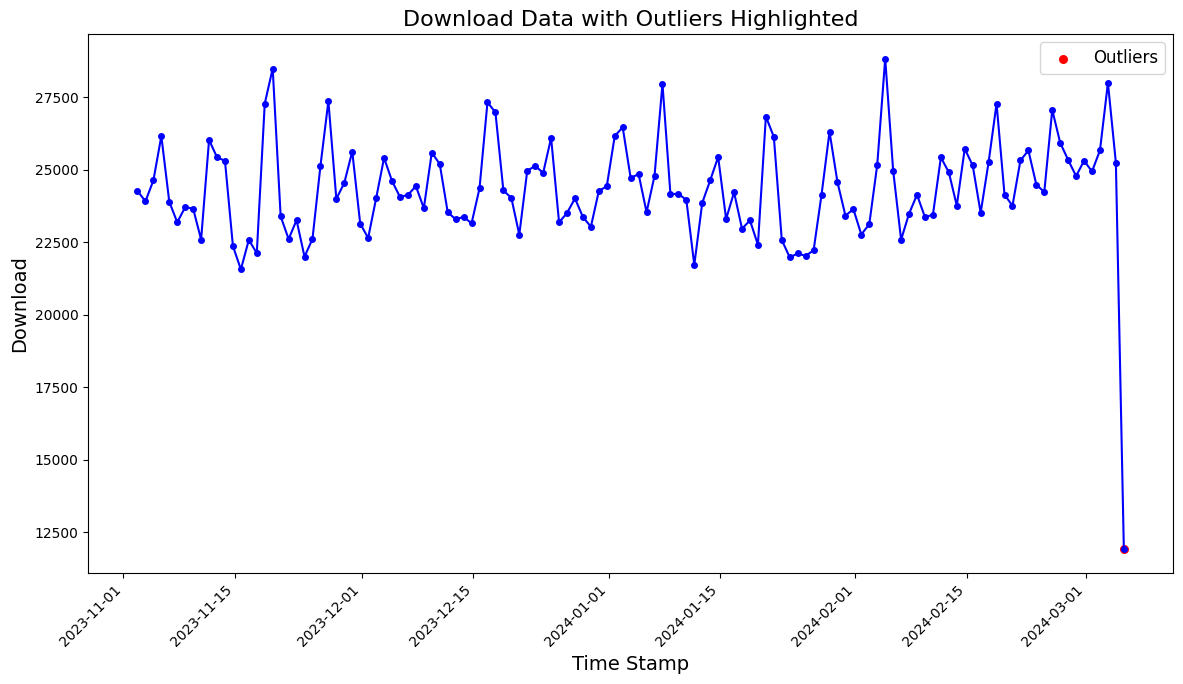

In [837]:
# Assuming df is your DataFrame and 'OUTLIER' is a column indicating the outliers
plt.figure(figsize=(14, 7))

# Plot the normal data points
plt.plot(check_data['TIME_STAMP'], check_data['DOWNLOAD'], color='blue', linestyle='-', marker='o', markersize=4)

# Plot the anomalies
outliers = check_data[check_data['OUTLIER'] == True]
plt.scatter(outliers['TIME_STAMP'], outliers['DOWNLOAD'], label='Outliers', color='red', s=30)

# Add titles and labels
plt.title('Download Data with Outliers Highlighted', fontsize=16)
plt.xlabel('Time Stamp', fontsize=14)
plt.ylabel('Download', fontsize=14)

# Enhance legend
plt.legend(loc='upper right', fontsize=12)

# Improve x-axis ticks
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()



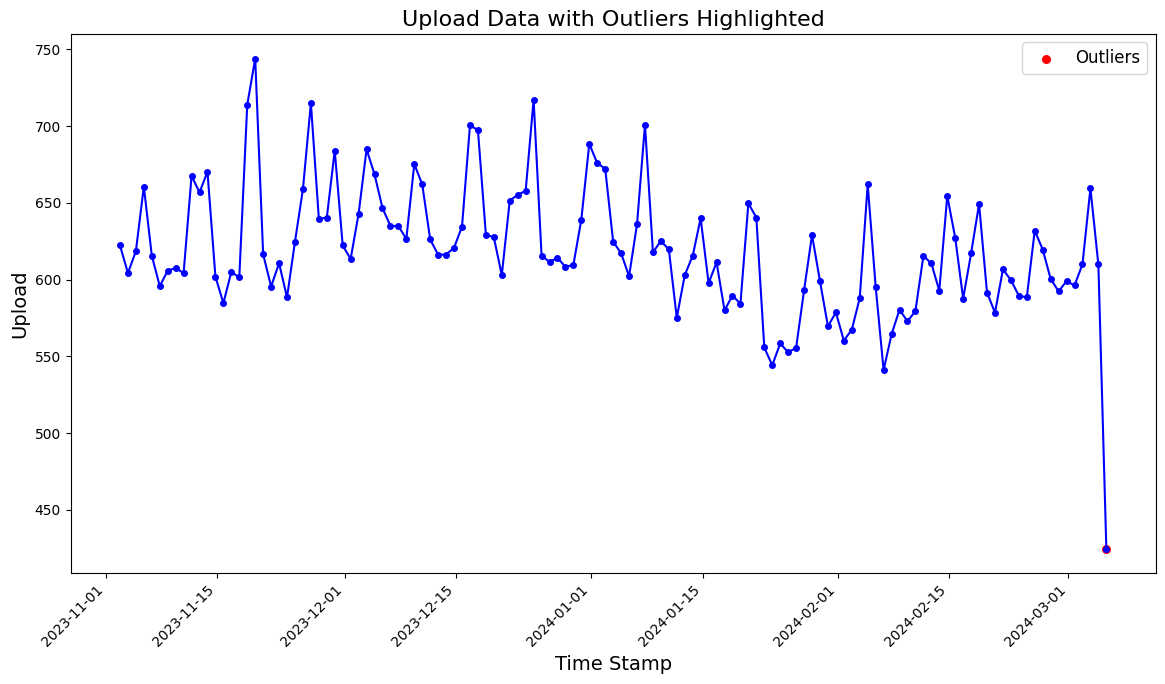

In [839]:
# Assuming df is your DataFrame and 'OUTLIER' is a column indicating the outliers
plt.figure(figsize=(14, 7))

# Plot the normal data points
plt.plot(check_data['TIME_STAMP'], check_data['UPLOAD'], color='blue', linestyle='-', marker='o', markersize=4)


# Plot the anomalies
outliers = check_data[check_data['OUTLIER'] == True]
plt.scatter(outliers['TIME_STAMP'], outliers['UPLOAD'], label='Outliers', color='red', s=30)

# Add titles and labels
plt.title('Upload Data with Outliers Highlighted', fontsize=16)
plt.xlabel('Time Stamp', fontsize=14)
plt.ylabel('Upload', fontsize=14)

# Enhance legend
plt.legend(loc='upper right', fontsize=12)

# Improve x-axis ticks
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


# Anomaly Detection with Prophet

In [810]:
# Adjust proper format for the Prophet
prophet_df = df[['TIME_STAMP', 'DOWNLOAD']].rename(columns={'TIME_STAMP': 'ds', 'DOWNLOAD': 'y'})


In [811]:
# Build the model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True,changepoint_range=0.95)


In [812]:
# Add country spesific days information
prophet_model.add_country_holidays(country_name='TR')


In [813]:
prophet_model.fit(prophet_df)

10:50:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing


In [814]:
future = prophet_model.make_future_dataframe(periods=168, freq='h')


In [815]:
forecast = prophet_model.predict(future)


/opt/conda/lib/python3.10/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/conda/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


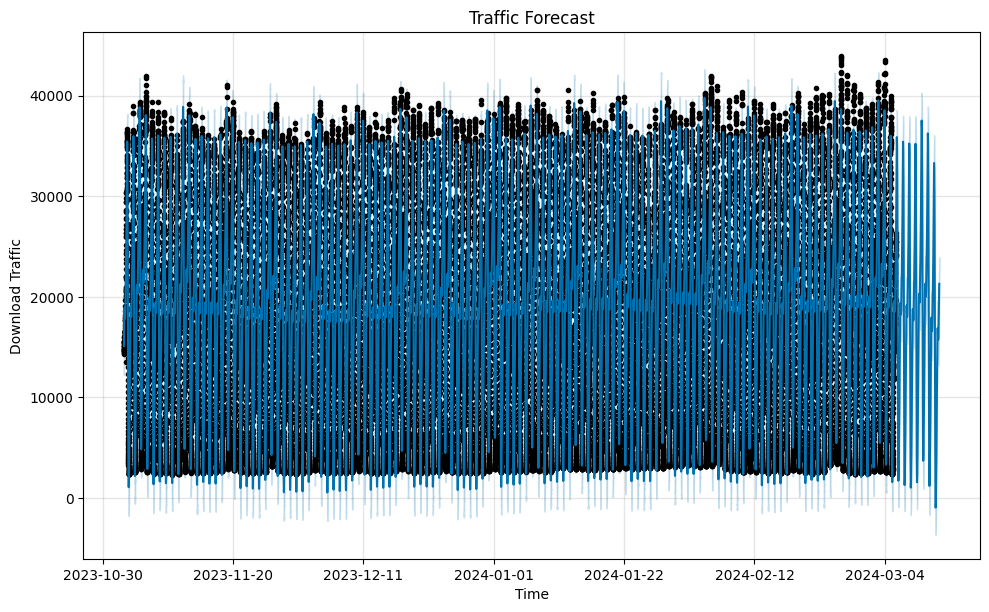

In [816]:
# Plot the forecast
fig = prophet_model.plot(forecast)
plt.title('Traffic Forecast')
plt.xlabel('Time')
plt.ylabel('Download Traffic')
plt.show()

In [817]:
prophet_df = prophet_df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')


In [852]:
prophet_df['anomaly'] = prophet_df.apply(
    lambda row: row['y'] < row['yhat_lower']/1.5 or row['y'] > row['yhat_upper']*1.5, axis=1)

In [845]:
check_outlier = prophet_df[prophet_df['ds'] == "2024-03-05 18:25:00"]
check_outlier

,ds,y,yhat,yhat_lower,yhat_upper,anomaly
35428,2024-03-05 18:25:00,11927.017,24125.983129,21494.975249,26769.315721,True


In [846]:
prophet_df.loc[prophet_df["anomaly"] == True].shape[0]


289

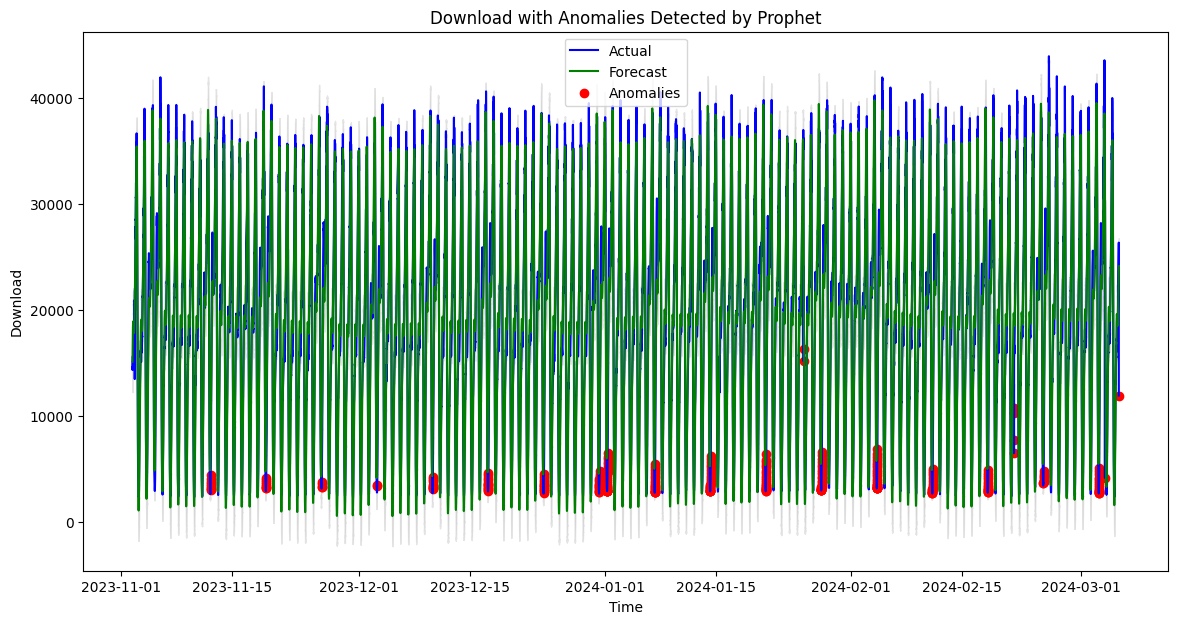

In [853]:
plt.figure(figsize=(14, 7))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Actual', color='blue')
plt.plot(prophet_df['ds'], prophet_df['yhat'], label='Forecast', color='green')
plt.fill_between(prophet_df['ds'], prophet_df['yhat_lower'], prophet_df['yhat_upper'], color='gray', alpha=0.2)
anomalies = prophet_df[prophet_df['anomaly'] == True]
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies')
plt.title('Download with Anomalies Detected by Prophet')
plt.xlabel('Time')
plt.ylabel('Download')
plt.legend()
plt.show()

# Bonus 

In [822]:
hourly_traffic = df.groupby('HOUR')[['DOWNLOAD', 'UPLOAD']].mean()


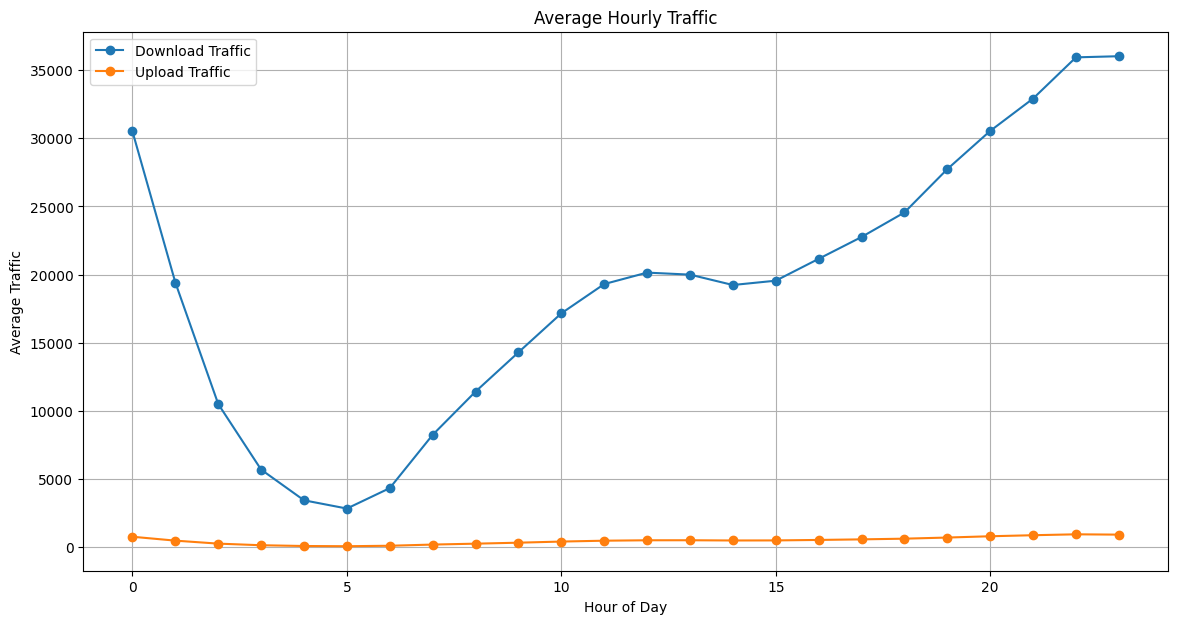

In [823]:
# Plot hourly traffic
plt.figure(figsize=(14, 7))
plt.plot(hourly_traffic.index, hourly_traffic['DOWNLOAD'], marker='o', label='Download Traffic')
plt.plot(hourly_traffic.index, hourly_traffic['UPLOAD'], marker='o', label='Upload Traffic')
plt.title('Average Hourly Traffic')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic')
plt.legend()
plt.grid(True)
plt.show()

* ANSWER : The busiest hours are between 20:00 and 00.00, with the highest average download and upload traffic.
